# **FLOW BASED INTRUSION DETECTION ON UNSW-NB15 DATASET**

## **Environment Setup**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Importing Libraries**

In [2]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import imblearn
import sklearn
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

## **Load Data**
Datasets with 2 different CSV files, each contains same type of attack data at different times.

In [3]:

# Load UNSW_NB15 Train dataset
UTrain = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Datasets/UNSW_NB15_training-set.csv')

# Load UNSW_NB15 Test dataset
UTest = pd.read_csv('/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Datasets/ UNSW_NB15_testing-set.csv')


UTrain.shape, UTest.shape

((175341, 45), (82332, 45))

In [4]:
combinedData = pd.concat([UTrain, UTest]).drop(['id'],axis=1)

In [5]:
combinedData.tail(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
82329,0.000000,arp,-,INT,1,0,46,0,0.0000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.0000,0,...,1,1,0,0,0,1,1,1,Normal,0
82331,0.000009,udp,-,INT,2,0,104,0,111111.1072,254,...,1,1,0,0,0,1,1,0,Normal,0


In [6]:
combinedData.shape

(257673, 44)

In [7]:
combinedData.dtypes.value_counts()

int64      29
float64    11
object      4
dtype: int64

Some general info about the dataset. It contains roughly 175341 records across 45 columns. Data consists of mostly int64 and float64 types and  four object type.

## **Data Cleaning**
This section contains data cleaning code. We go through the process of renaming columns, removing NaN to get the data ready for visualization and model training.

### Renaming columns

In [8]:
# Removing whitespaces in column names.
attacks = [col.replace(' ', '') for col in combinedData.columns]
combinedData.columns = attacks

In [9]:
# lets see that 'subclass' column contains some wierd characters. 
combinedData["attack_cat"].unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

### Removing NULL values

Checking for any null values in dataset and dropping such values so that our models receive correct dataset in input for training

In [10]:
# Checking if there are any NULL values in the dataset.
combinedData.isnull().values.any()

False

In [11]:
# Checking which column/s contain NULL values.
[col for col in combinedData if combinedData[col].isnull().values.any()]

[]

checking for any values containing - in service column

In [12]:
combinedData[combinedData['service']=='-']

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0
5,0.380537,tcp,-,FIN,10,6,534,268,39.417980,254,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,2,0,0,0,2,1,0,Normal,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,0,0,0,3,2,0,Normal,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,0,0,0,1,1,1,Normal,0


replacing - values with nan for service column

In [13]:
combinedData['service'].replace('-',np.nan,inplace=True)

finding totoal nan values in dataset again

In [14]:
combinedData.isnull().sum()

dur                       0
proto                     0
service              141321
state                     0
spkts                     0
dpkts                     0
sbytes                    0
dbytes                    0
rate                      0
sttl                      0
dttl                      0
sload                     0
dload                     0
sloss                     0
dloss                     0
sinpkt                    0
dinpkt                    0
sjit                      0
djit                      0
swin                      0
stcpb                     0
dtcpb                     0
dwin                      0
tcprtt                    0
synack                    0
ackdat                    0
smean                     0
dmean                     0
trans_depth               0
response_body_len         0
ct_srv_src                0
ct_state_ttl              0
ct_dst_ltm                0
ct_src_dport_ltm          0
ct_dst_sport_ltm          0
ct_dst_src_ltm      

Dataset shape before removing nan values

In [15]:
combinedData.shape

(257673, 44)

Removing rows with nan values from dataset

In [16]:
combinedData.dropna(inplace=True)

Dataset shape after removing nan values

In [17]:
combinedData.shape

(116352, 44)

In [18]:
combinedData.isnull().any().any()

False

Dropping 'attack_cat' column in flow based approach as we need label

In [19]:
#for packet based approachwe need attack category and  no need of label category, 
combinedData.drop(['attack_cat'],axis=1,inplace=True)
combinedData.shape

(116352, 43)

## **Data Visualization**
Our aim here is to check whether an intrusion is detected or not. Here we do not go deeper into the classification of the attacks. Thus, we change column which maps label 'normal' to 0 and any intrusion as 1. We then plot a pie chart to visualize this distribution.

### **Flow Intrsuion Detection**



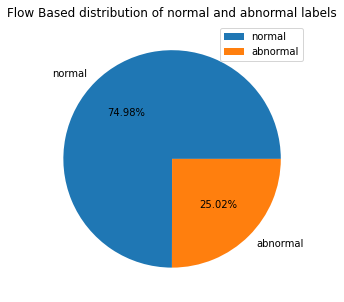

In [20]:
plt.figure(figsize=(5,5))
plt.pie(combinedData.label.value_counts(),labels=['normal','abnormal'],autopct='%0.2f%%')
plt.title("Flow Based distribution of normal and abnormal labels",fontsize=12)
plt.legend()
plt.savefig('/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Images/Pie_chart_binary.png')
plt.show()

In [21]:
# creating a dataframe with binary labels (normal,anomaly)
flow_data = combinedData.copy()
flow_label = pd.DataFrame(flow_data.label)

In [22]:
# pie chart distribution of normal and anomaly labels
le1 = preprocessing.LabelEncoder()
enc_label = flow_label.apply(le1.fit_transform)
flow_data['intrusion'] = enc_label

In [23]:
np.save("/content/drive/MyDrive/2117493_PROJECT/NIDS/UNSW-NB15 /Labels",le1.classes_,allow_pickle=True)

## **Function to encode string features**

This section is performing the encoding of string features which is required for nerual network training. As we majority of features in numerical form, we want the string features to have some numerical values so that neural network can train on all features including string features.

Visualizing string features

In [24]:
combinedData.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
11,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,62,...,1,1,2,0,0,0,1,1,0,0
15,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,254,...,1,1,4,0,0,0,2,1,0,0
17,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,62,...,1,1,2,0,0,1,1,3,0,0
21,0.338017,tcp,http,FIN,10,6,998,268,44.376468,254,...,1,1,1,0,0,1,2,3,0,0


Performing encoding of string features

In [25]:
le = LabelEncoder()
combinedData['proto'] = le.fit_transform(combinedData['proto'])
combinedData['service'] = le.fit_transform(combinedData['service'])
combinedData['state'] = le.fit_transform(combinedData['state'])

Separating Features and target for Model training

In [26]:
XX = combinedData.iloc[:,:-1].values
YY = combinedData.iloc[:,-1].values
YY = YY.reshape(-1,1)
print([XX.shape, YY.shape])
YY

[(116352, 42), (116352, 1)]


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()
yy = le.fit_transform(YY).reshape(-1,1)
YY = ohe.fit_transform(yy).toarray()
XX.shape, yy.shape
# Y

((116352, 42), (116352, 1))

In [28]:
combinedData.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')

In [29]:
cols_ = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports']

In [30]:
dataX = pd.DataFrame(XX,columns=cols_)
dataY = pd.DataFrame(yy)
dataY

,0
0,0
1,0
2,0
3,0
4,0
...,...
116347,0
116348,0
116349,0
116350,0


Checking for null values in target

In [31]:
dataY.isnull().values.any()

False

In [32]:
is_all_zero = np.all((dataY == 0))
if is_all_zero:
    print('Array contains only 0')
else:
    print('Array has non-zero items too')


Array has non-zero items too


## **Feature Selection**
Since there is such a large number of features, it is possible that some features are redundant. Let us print a correlation matrix

In [33]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import itertools    

model_ = DecisionTreeClassifier()

# create RFE model and select 15 attributes
rec = RFE(model_, n_features_to_select = 15)
rec = rec.fit(dataX, dataY)

# summarize the selection of the attributes
featuresMap = [(x, n) for x, n in itertools.zip_longest(rec.get_support(), dataX.columns)]
selectedFeatures = [n for x, n in featuresMap if x == True]

print(selectedFeatures)

['sbytes', 'dbytes', 'sttl', 'sload', 'dload', 'dinpkt', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'smean', 'dmean', 'response_body_len', 'ct_dst_src_ltm', 'ct_srv_dst']


Selecting Features

In [34]:
dataX = dataX[selectedFeatures]
X = dataX[selectedFeatures]
print('15 selected features \n')
X.head()

15 selected features 



,sbytes,dbytes,sttl,sload,dload,dinpkt,stcpb,dtcpb,tcprtt,synack,smean,dmean,response_body_len,ct_dst_src_ltm,ct_srv_dst
0,628.0,770.0,62.0,2.740179e+03,3358.622070,90.235726,1.107119e+09,1.047443e+09,0.000000,0.000000,52.0,64.0,0.0,3.0,1.0
1,56329.0,2212.0,62.0,2.118251e+05,8152.559082,75.092445,1.824723e+09,8.607167e+08,0.131140,0.052852,909.0,79.0,0.0,2.0,1.0
2,138.0,0.0,254.0,2.760000e+08,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,69.0,0.0,0.0,4.0,1.0
3,860.0,1096.0,62.0,1.573347e+04,19494.048830,47.669145,3.882971e+09,3.084071e+09,0.120313,0.059201,86.0,137.0,103.0,2.0,3.0
4,998.0,268.0,254.0,2.127704e+04,5301.508789,56.579801,2.665974e+09,3.521362e+09,0.154433,0.055109,100.0,45.0,0.0,1.0,3.0


## **Dataset Splitting**
The next step is to split training and testing data. For this we will use sklearn function train_test_split(). This step is important so we can have representative data for evaluating our model. Both train and test samples should contain similar data variance.

In [36]:
from sklearn.model_selection import train_test_split
# The next step is to split training and testing data. For this we will use sklearn function train_test_split().
i_train, i_test, j_train, j_test = train_test_split(dataX, dataY, train_size=0.7,test_size=0.3,  random_state = 1, shuffle=True)

In [38]:
i_train.shape, j_train.shape, i_test.shape, j_test.shape    # test is larger... good 

((81446, 15), (81446, 1), (34906, 15), (34906, 1))

## **Scaling Numerical Attributes**
The next few cells contain the code for scaling the data into the size adequate for the Models.

In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
i_train = sc.fit_transform(i_train)
i_test = sc.transform(i_test)
i_train.shape, i_test.shape

((81446, 15), (34906, 15))

## **Machine-Learning model training**

importing required libraries for ml model

In [40]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error,roc_auc_score,cohen_kappa_score)
import sklearn.metrics as metrics

### Training four base learners: decision tree, random forest, XGBoost

#### Apply DT

Training Decision Tree

Accuracy of Decision Tree: 0.978828854638171
              precision    recall  f1-score   support

     anomaly       0.95      0.96      0.96      8745
      normal       0.99      0.98      0.99     26161

    accuracy                           0.98     34906
   macro avg       0.97      0.97      0.97     34906
weighted avg       0.98      0.98      0.98     34906



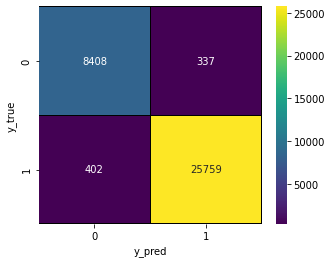

In [41]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(i_train, j_train) 

y_predict=dt.predict(i_test)
y_true=j_test

dt_score=dt.score(i_test, j_test)
print('Accuracy of Decision Tree: '+ str(dt_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names = ['anomaly', 'normal']))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply RF

Training Random Forest

Accuracy of Random Forest: 0.9841288030711053
              precision    recall  f1-score   support

     anomaly       0.97      0.97      0.97      8745
      normal       0.99      0.99      0.99     26161

    accuracy                           0.98     34906
   macro avg       0.98      0.98      0.98     34906
weighted avg       0.98      0.98      0.98     34906



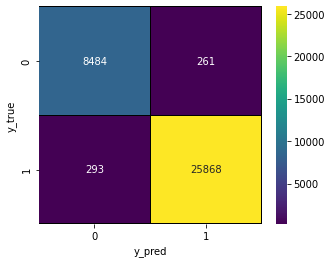

In [42]:
##@title  { vertical-output: true, display-mode: "both" }
rf = RandomForestClassifier(random_state = 0)
rf.fit(i_train, j_train) 

y_predict=rf.predict(i_test)
y_true=j_test

rf_score=rf.score(i_test, j_test)
print('Accuracy of Random Forest: '+ str(rf_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names = ['anomaly', 'normal']))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Apply XGBoost

Training XGBoost

Accuracy of Gradient Boosting: 0.9767375236349052
              precision    recall  f1-score   support

     anomaly       0.97      0.93      0.95      8745
      normal       0.98      0.99      0.98     26161

    accuracy                           0.98     34906
   macro avg       0.98      0.96      0.97     34906
weighted avg       0.98      0.98      0.98     34906



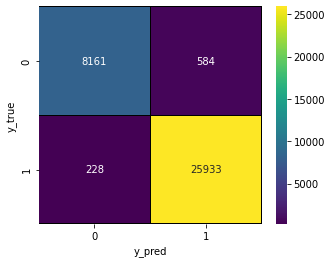

In [43]:
##@title  { vertical-output: true, display-mode: "both" }
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(i_train,j_train)

y_predict=xg.predict(i_test)
y_true=j_test

xg_score=xg.score(i_test, j_test)
print('Accuracy of Gradient Boosting: '+ str(xg_score))
cr = print(metrics.classification_report(y_true, y_predict, target_names = ['anomaly', 'normal']))

cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.1,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## **Deep-Learning Model Training**
In this stage we go by explaning parts of the network and its hyperparameters.

### Bi-directional LSTM Model


In [44]:
#importing lobraries
import keras
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense,Dropout, BatchNormalization, Activation, Bidirectional, LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from IPython.core.display import Image

In [45]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, YY,  train_size=0.7, test_size=0.3,  random_state = 1, shuffle=True)
print([Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape])

[(81446, 15), (34906, 15), (81446, 2), (34906, 2)]


In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
Xtrain.shape, Xtest.shape

((81446, 15), (34906, 15))

### Reshaping our data into 3D, which is required format of LSTM input

In [47]:
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1], 1)
Xtrain.shape, Xtest.shape

((81446, 15, 1), (34906, 15, 1))

### Structure of our BiLSTM

In [48]:
timesteps = 60

In [49]:
blstm_model = tf.keras.Sequential()
blstm_model.add(Bidirectional(LSTM(60, return_sequences=True, activation= 'relu', input_shape=(Xtrain.shape[1], timesteps, 1))))
blstm_model.add(Bidirectional(LSTM(60,return_sequences= False, activation= 'relu')))
blstm_model.add(tf.keras.layers.Dropout(0.2))
blstm_model.add(Dense(2, activation= 'softmax'))
blstm_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history2 = blstm_model.fit(Xtrain, Ytrain,  epochs=10, validation_split=0.3, batch_size=700).history
#model.summary()

Epoch 1/10
82/82 [==============================] - 33s 336ms/step - loss: 0.4335 - accuracy: 0.8041 - val_loss: 0.1891 - val_accuracy: 0.9433
Epoch 2/10
82/82 [==============================] - 27s 329ms/step - loss: 0.2381 - accuracy: 0.9465 - val_loss: 0.1891 - val_accuracy: 0.9325
Epoch 3/10
82/82 [==============================] - 29s 355ms/step - loss: 0.1302 - accuracy: 0.9550 - val_loss: 0.1110 - val_accuracy: 0.9595
Epoch 4/10
82/82 [==============================] - 27s 334ms/step - loss: 0.1132 - accuracy: 0.9584 - val_loss: 0.1049 - val_accuracy: 0.9603
Epoch 5/10
82/82 [==============================] - 27s 335ms/step - loss: 0.1087 - accuracy: 0.9581 - val_loss: 0.0983 - val_accuracy: 0.9605
Epoch 6/10
82/82 [==============================] - 27s 331ms/step - loss: 0.0961 - accuracy: 0.9611 - val_loss: 0.0920 - val_accuracy: 0.9633
Epoch 7/10
82/82 [==============================] - 29s 353ms/step - loss: 0.0878 - accuracy: 0.9662 - val_loss: 0.0784 - val_accuracy: 0.9678

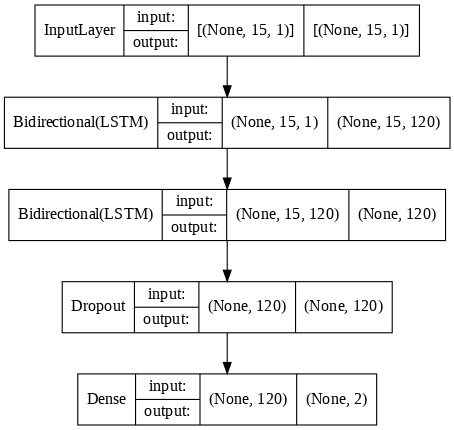

In [50]:
plot_model(blstm_model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

Evaluating our trained BiLSTM

1091/1091 [==============================] - 10s 9ms/step - loss: 0.0793 - accuracy: 0.9700
Accuracy of BLSTM: 0.9699764847755432
              precision    recall  f1-score   support

     anomaly       0.97      0.90      0.94      8745
      normal       0.97      0.99      0.98     26161

    accuracy                           0.97     34906
   macro avg       0.97      0.95      0.96     34906
weighted avg       0.97      0.97      0.97     34906



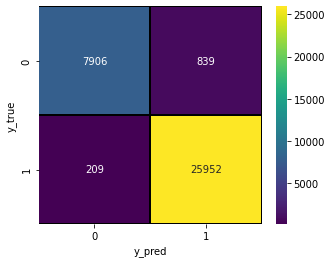

In [51]:
##@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
#We now predict the output for our test dataset. If the prediction is greater than 0.5 then the output is 1 else the output is 0
blstm_score = blstm_model.evaluate(Xtest, Ytest)
y_pred=blstm_model.predict(Xtest)
b_predict=np.argmax(y_pred, axis=1)
b_test=np.argmax(Ytest, axis=1)

print('Accuracy of BLSTM: '+ str(blstm_score[1]))
print(metrics.classification_report(b_test, np.round(b_predict), target_names = ['anomaly', 'normal']))

cm=confusion_matrix(b_test, b_predict)
f,ax=plt.subplots(figsize=(5,4))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="k",fmt=".0f",ax=ax, cmap = 'viridis')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Accuracy Curve of our trained BiLSTM

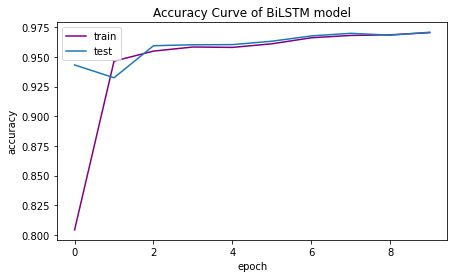

In [52]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of accuracy vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['accuracy'], 'purple')
plt.plot(history2['val_accuracy'],'')

plt.title('Accuracy Curve of BiLSTM model')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper left');

### Loss Curve of our trained BiLSTM

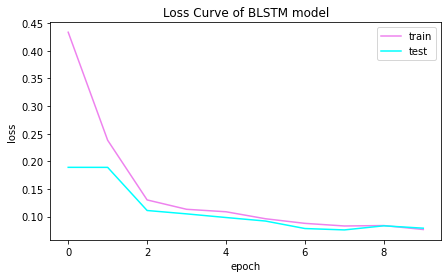

In [53]:
#@title  { vertical-output: true, form-width: "45%", display-mode: "both" }
# Plot of loss vs epoch of train and test dataset

plt.figure(figsize=(7,4))
plt.plot(history2['loss'], 'violet')
plt.plot(history2['val_loss'], 'cyan')

plt.title('Loss Curve of BLSTM model')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper right');

## **Models Comparision**
The table below tabulates all the score accuracies from each model for a clear comparision.

In [54]:
result = pd.DataFrame({ 'Classifiers': ['DecisionTree Classifier', 'RandomForest Classifier','GradientBoosting Classifier', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})

result

,Classifiers,Score
0,DecisionTree Classifier,0.978829
1,RandomForest Classifier,0.984129
2,GradientBoosting Classifier,0.976738
3,Bidirectional LSTM,0.969976


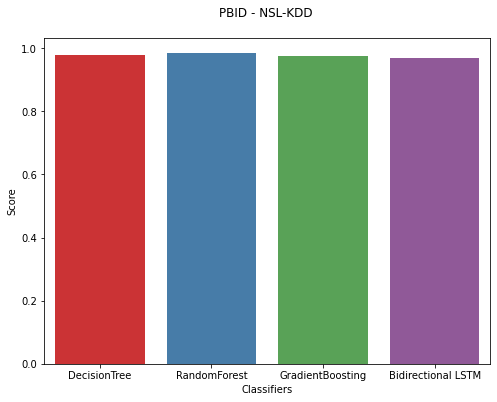

In [55]:
chart = pd.DataFrame({ 'Classifiers': ['DecisionTree', 'RandomForest','GradientBoosting', 'Bidirectional LSTM'],
                         'Score': [dt_score, rf_score, xg_score, blstm_score[1]]})
plt.figure(figsize=(8,6))
ax=sns.barplot(data = chart, x = 'Classifiers', y = 'Score', palette='Set1')
ax.set_xticklabels(ax.get_xticklabels())
plt.title('PBID - NSL-KDD \n ', fontsize=12)
#plt.legend([],[], frameon=True)
plt.show()

From these tested models, the results table shows that Random Forest classifier boast a 99% accuracy. 
The Deep Learning Model IS even not far behind which had 95% around for  BLSTM.

In conclusion, the Random Forest classifier performs Very well on comparing with all the models in detecting intrusion on the network. DecisionTree classifier are a close second in detecting intrusions and giving reliable predictions.

Finally To evaluate more about these models, the ROC curve and Calibration plots for multi-class classification need to be implemented thats done in second stage of this study.